In [1]:
import psi4

In [2]:
psi4.set_output_file('output.dat', False)

PosixPath('output.dat')

In [3]:
#! Sample HF/cc-pVDZ H2O Computation

psi4.set_memory('500 MB')

h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

psi4.energy('scf/cc-pvdz')

-76.0266327350902

In [4]:
#! Sample UHF/6-31G** CH2 Computation

R = 1.075
A = 133.93

ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A)
)

psi4.set_options({'reference': 'uhf'})
psi4.energy('scf/6-31g**')

-38.92533462893707

In [5]:
psi4.set_options({'reference': 'rhf'})
psi4.optimize('scf/cc-pvdz', molecule=h2o)

Optimizer: Optimization complete!


-76.02703272937481

In [6]:
scf_e, scf_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2o, return_wfn=True)

In [7]:
# Example SAPT computation for ethene*ethyne (*i.e.*, ethylene*acetylene).
# Test case 16 from S22 Database

dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")

In [8]:
psi4.set_options({'scf_type': 'df',
                  'freeze_core': True})

psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)

-0.0022355823909805178

In [24]:
#! Example potential energy surface scan and CP-correction for Ne2

ne2_geometry = """
Ne
--
Ne 1 {0}
"""

Rvals = [2.5, 3.0, 4.0]

psi4.set_options({'freeze_core': True})

# Initialize a blank dictionary of counterpoise corrected energies
# (Need this for the syntax below to work)

ecp = {}

for R in Rvals:
    ne2 = psi4.geometry(ne2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ne2)

# Prints to screen
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

# Prints to output.dat
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))


CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies


          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            2.5                        0.758605
            3.0                        0.015968
            4.0                        -0.016215


In [42]:
import psi4
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define distances in Angstroms
# Coarse range for distances outside 3.7–3.9 Å
coarse_distances = np.linspace(3.5, 3.7, 5)  # 5 points from 3.5 to just under 3.7
coarse_distances = np.append(coarse_distances, np.linspace(3.9, 6.0, 15))  # 15 points from just over 3.9 to 6.0

# Fine range for distances between 3.7 and 3.9 Å
fine_distances = np.linspace(3.7, 3.9, 10)  # 10 points between 3.7 and 3.9

# Combine both ranges
distances = np.unique(np.concatenate((coarse_distances, fine_distances)))

# distances = np.linspace(3.5, 6.0, 20)

# Placeholder for storing energies
energies = []

# Define Argon dimer geometry
argon_geometry_template = """
Ar
--
Ar 1 {0}
"""

# Loop over distances to calculate interaction energy
for R in distances:
    molecule = psi4.geometry(argon_geometry_template.format(R))
    psi4.set_options({'freeze_core': True})
    
    # Using a CCSD(T) calculation with counterpoise correction for accuracy
    energy = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=molecule)
    energies.append(energy * psi4.constants.hartree2kcalmol)  # Convert to kcal/mol

# Convert energies to NumPy array for further processing
energies = np.array(energies)

In [43]:
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)


In [47]:
# Initial guesses for sigma and epsilon
initial_guess = [3.6, 0.1]

# Curve fitting to determine sigma and epsilon
params, covariance = curve_fit(lj, distances, energies, p0=initial_guess)
sigma_fit, eps_fit = params
print(f"Fitted sigma: {sigma_fit}, Fitted epsilon: {eps_fit}")


Fitted sigma: 3.6400387786486386, Fitted epsilon: 0.12290199837054235


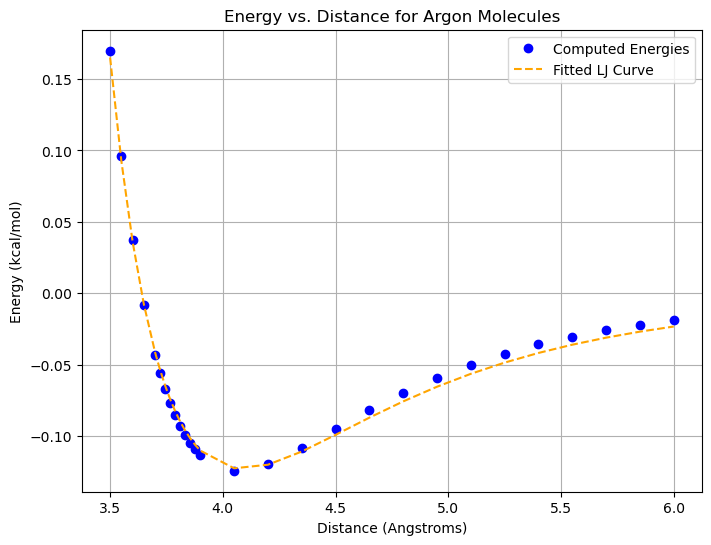

In [45]:
# Generate fitted LJ curve data
fitted_energies = lj(distances, sigma_fit, eps_fit)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(distances, energies, 'o', label="Computed Energies", color='blue')
plt.plot(distances, fitted_energies, '--', label="Fitted LJ Curve", color='orange')
plt.xlabel("Distance (Angstroms)")
plt.ylabel("Energy (kcal/mol)")
plt.title("Energy vs. Distance for Argon Molecules")
plt.legend()
plt.grid(True)

# Save the figure in the Figures directory
plt.savefig("./Figure/argon_energy_vs_distance.png")
plt.show()


In [37]:
2**(1/6) * 3.4

3.816370964251868